# IMA204 Practical Session - Segmentation of medical images



## ADD your name(s) here: <br>

KHELIFI Fouad

# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
import scipy
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


# PRINT VERSIONS
#print("os.__version__",os.__version__)
print("np.__version__",np.__version__)
print("matplotlib.__version__",matplotlib.__version__)
print("skimage.__version__",skimage.__version__)
print("scipy.__version__",scipy.__version__)
print("cv2.__version__",cv2.__version__)
#print("glob.__version__",glob.__version__)

np.__version__ 1.26.4
matplotlib.__version__ 3.9.4
skimage.__version__ 0.24.0
scipy.__version__ 1.13.1
cv2.__version__ 4.6.0


In [2]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  ./data/abdominalCT_axial\CTs4.tiff
Label values in gt mask image [  0 127]
There is no tumor


Text(0.5, 1.0, 'Image +contour tumor')

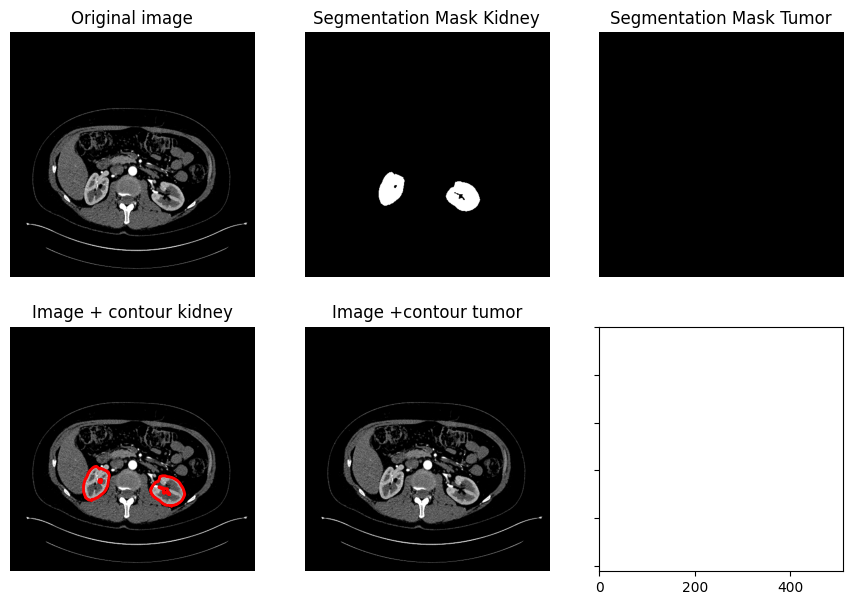

In [3]:
abdominalCT_path = './data/abdominalCT_axial'  
os.listdir(abdominalCT_path)
listImagesabdCT = glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm = 3 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print('Label values in gt mask image', np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")

# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['./data/brainMRI\\MRIs1-seg.png', './data/brainMRI\\MRIs2-seg.png', './data/brainMRI\\MRIs3-seg.png', './data/brainMRI\\MRIs4-seg.png']
Reading image  ./data/brainMRI\MRIs4.png


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

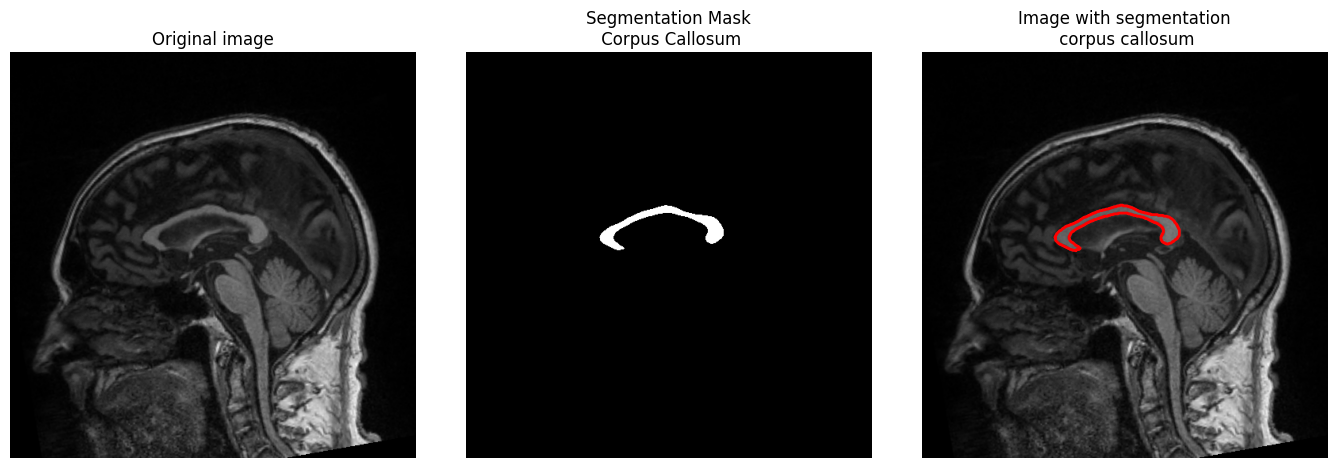

In [4]:
brainMRI_path = './data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 3 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")

# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


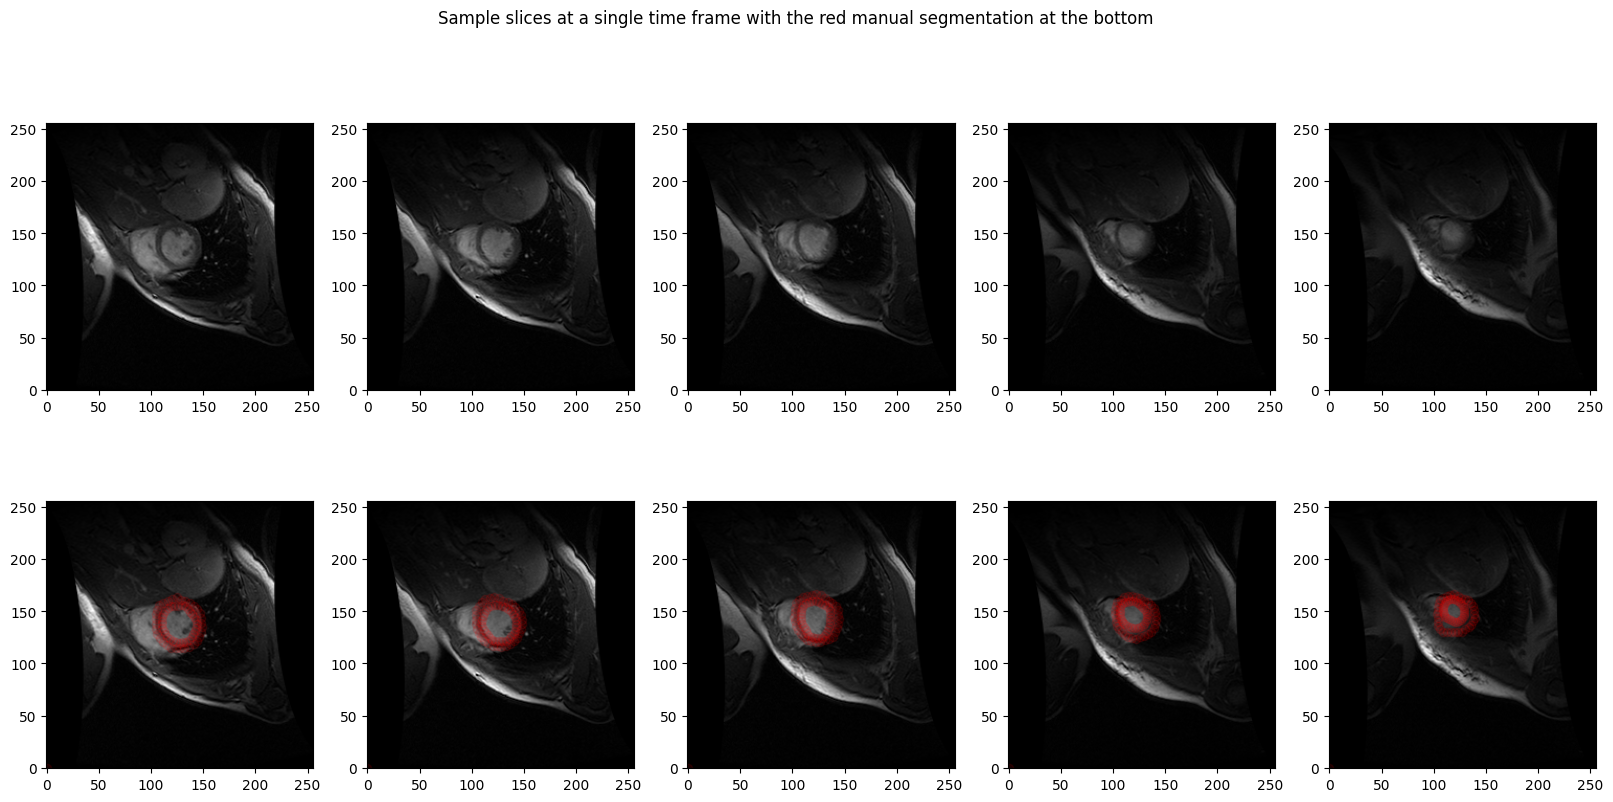

In [5]:
# Read one case
MRIheart_path = './data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 6
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1); 

## For cardiac MRI: how to create a binary mask from the provided contours

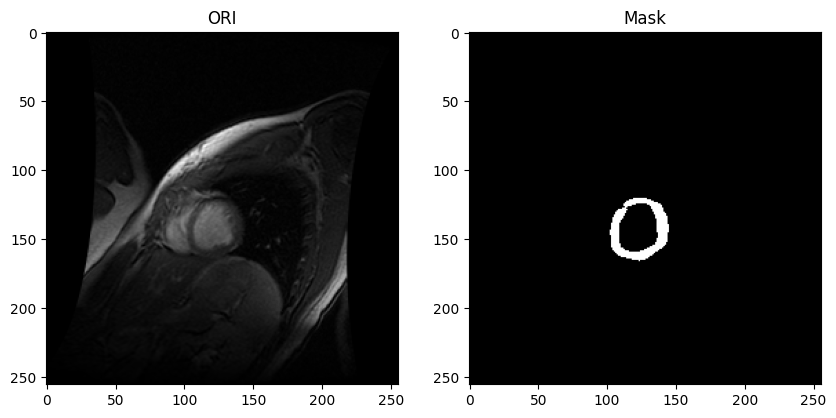

In [7]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incentives to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



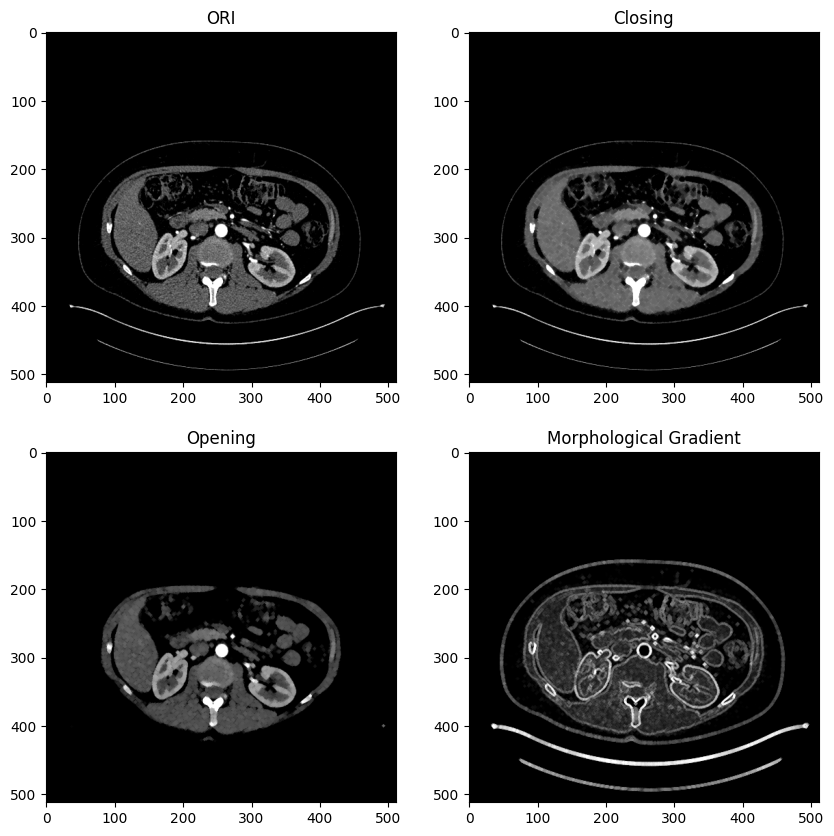

In [8]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Morphological Gradient")

plt.show()

# Preliminaries
## Regular filtering

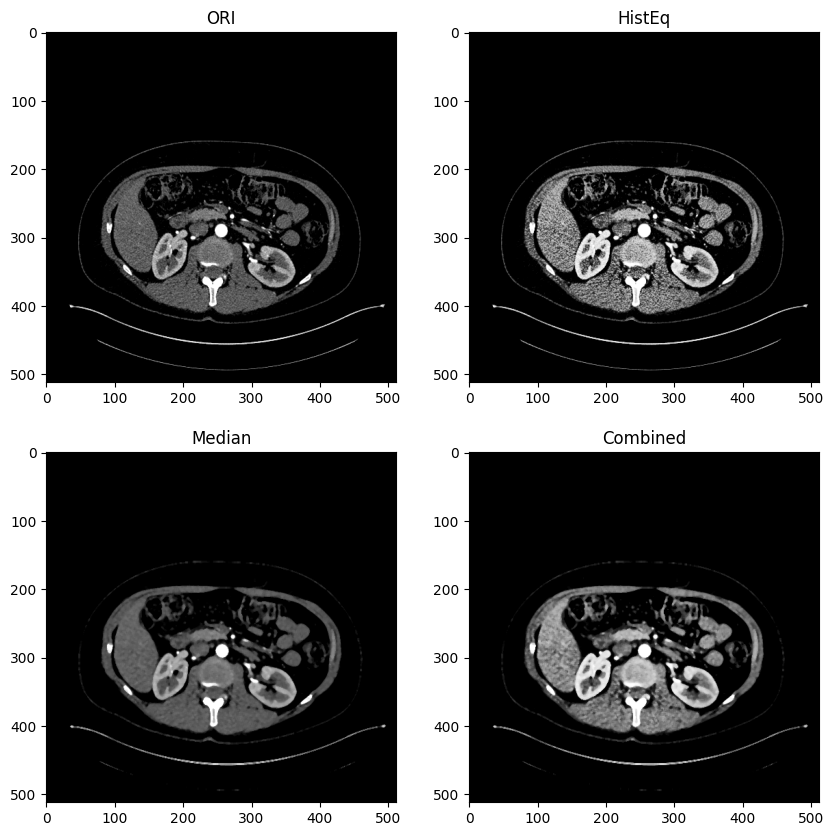

In [9]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT DETAILS:

__Overall task:__ <br> 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure(s) of interest**. For the postprocessing you can rely on extraction of connected components and apply some criteria (size, shape, position,..) to extract the component(s) that most likely correspond(s) to the structure(s) of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* __Cropping__ the field of view to remove the background (a common issue in medical images)
* Target a __range of intensity values__ based on learning from the gt masks and corresponding images you are given. 
* Learn __priors on shape/intensity statistics__ from the provided gt masks


## Kmeans routine to pre-segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



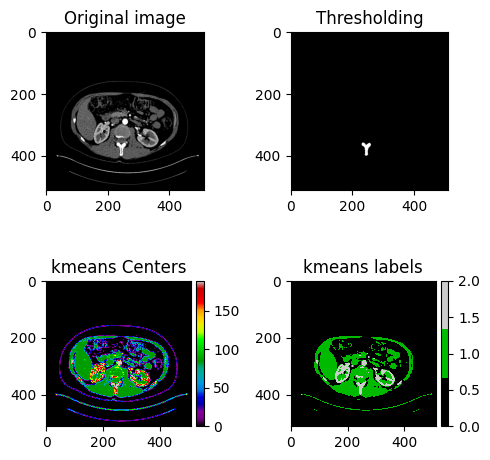

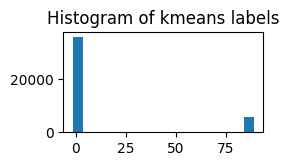

Nber of classes in Kmeans (input)=  3
Your intensity Target_value =  241
Distance of your Target_value to Kmeans Centers =  [240 154  51]
Your selected label (starting with 0)=  2


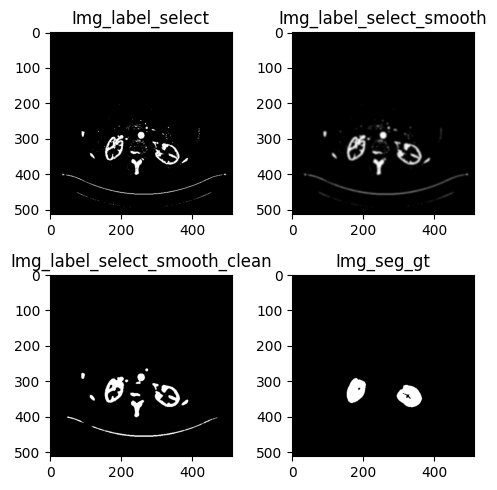

In [10]:
# Image use-case and HYPER-PARAMETER values provided as a good start

Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
nber_clusters    = 3; Target_value_thresh = 180 # For abdo image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For cardiac  image
# Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
# nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Figure: Display data
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')
tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')
tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')
fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
#Figure: plot histograms withins clusters from Kmeans
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
ax.set_title('Histogram of kmeans labels')
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0] 
Diff         = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)

# Prints: 
print('Nber of classes in Kmeans (input)= ', nber_clusters)
print('Your intensity Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Kmeans Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[0].set_title('Img_label_select')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[1].set_title('Img_label_select_smooth')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[2].set_title('Img_label_select_smooth_clean')
ax[3].imshow(Img_seg_gt, cmap='gray')
ax[3].set_title('Img_seg_gt')

fig.tight_layout()
plt.show()

## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases. 

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)
 



Max value in labels =  8
Number of connected components =  9


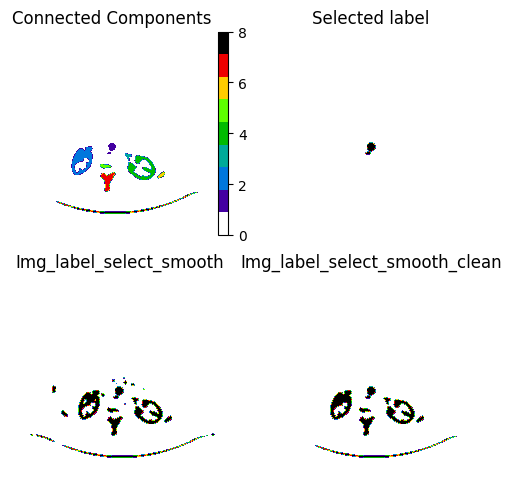

In [110]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');

plt.tight_layout()
plt.show()

## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment __TWO EXAMPLES__ from a single use-case. You must print in the report that code which was  run over the two cases. We need to see in your code that your were able to run the same pipeline on two cases without changing any hyperparameter or changing them based on image-specific information. So comment the code and list all hyperparameter values clearly at the start of the cell. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>
<br>
* __Extra point(s) if__ :
    1. you provide results on more use-cases or more than 2 examples per use case. <br>
    2. you test your segmentation pipeline on images degraded by noise for example. <br>


### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

# Answers

The assignment involves building a robust segmentation pipeline for medical images. Here's an implementation and explanation of how to approach the task:

---

### 1. General Pipeline Overview
1. **Preprocessing**: Enhance image contrast and reduce noise using regular filtering (e.g., histogram equalization and median filtering).  
2. **Segmentation**: Use k-means clustering and thresholding for initial segmentation.  
3. **Postprocessing**: Refine segmentation using morphological operations and connected components.  
4. **Evaluation**: Compare the segmentation results against ground truth using Dice coefficient and other quality metrics.  
5. **Automation**: Implement hyperparameter tuning and generalization to work on multiple examples without manual intervention.

---

### 2. Implementation of the Pipeline for the Abdominal CT

Here’s a concise description of the segmentation pipeline in bullet points:

- **Step 1: Preprocessing**
  - Enhance image contrast using adaptive histogram equalization.
  - Reduce noise with a median filter.

- **Step 2: K-Means Segmentation**
  - Apply k-means clustering to segment the image into `NBER_CLUSTERS` regions.

- **Step 3: Mean Intensity Calculation**
  - Calculate the mean pixel intensity for each k-means cluster.

- **Step 4: Target Label Selection**
  - Select the cluster label closest to a predefined target intensity.

- **Step 5: Binary Mask Generation**
  - Create a binary mask for the selected cluster.

- **Step 6: Postprocessing**
  - Smooth the binary mask using Gaussian filtering.
  - Remove small objects and fill small holes to clean up the mask.

- **Step 7: Connected Component Extraction**
  - Identify and analyze connected components in the cleaned mask.

- **Step 8: Morphological Closing**
  - Apply morphological closing to each connected component to smooth boundaries and fill small gaps.

- **Step 9: Component Filtering**
  - Filter connected components based on criteria like a minimum area and an almost circular shaped.

In [513]:
# --- Hyperparameters ---
RADIUS = 2                  # Radius for the morphological structuring element (used for basic morphology operations)
NBER_CLUSTERS = 4           # Number of clusters for k-means clustering (determines how the image is segmented)
TARGET_VALUE_THRESH = 150   # Intensity threshold to target specific pixel ranges for segmentation
GAUSSIAN_SIGMA = 3          # Sigma value for Gaussian smoothing (controls the level of blur applied to smooth edges)
SMOOTH_THRESH = 0.30        # Threshold for binarizing smoothed segmentation results
MIN_SIZE = 200              # Minimum size for connected components to be considered valid
AREA_THRESH = 50            # Minimum area threshold for removing small holes in segmentation
MEDIAN_SIZE = 5             # Size of the kernel for the median filter (used to reduce noise)
RADIUS_CLOSING = 30         # Radius for morphological closing (used to smooth the boundaries of connected components)
AREA_TOLERANCE = 0.25       # Tolerance for comparing the area of components to an ideal shape (e.g., a circle)
AREA_MIN = 1500             # Minimum area required for a component to be considered valid
#------------------------

In [244]:
# --- Helper Functions ---
def my_kmeans(image,k):
    """Performs KMeans clustering on an image.""" 
    pixel_vals = image.reshape((-1,1)) 
    
    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels


def calculate_dice(seg, gt):
    """Calculates the Dice coefficient."""
    intersection = np.sum((seg == 255) & (gt == 255))
    return 2 * intersection / (np.sum(seg) + np.sum(gt))

In [514]:
def filter_components(labels, numLabels, area_tolerance, area_min):
    """
    Filters connected components by their smoothness using circularity and how close the area is to 
    the area of a circle with the same perimeter.
    """
    filtered_labels = np.zeros_like(labels)

    for i in range(1, numLabels):  # Skip the background (index 0)
        
        component_mask = (labels == i).astype(np.uint8)

        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue

        external_area = cv2.contourArea(contours[0])
        perimeter = cv2.arcLength(contours[0], True)
        radius = perimeter / (2 * np.pi)
        circle_area = np.pi * radius ** 2
        
        if circle_area > 0:
            area_ratio = np.abs(1- external_area / circle_area)
        else:
            area_ratio = 1
            
        if area_ratio <= area_tolerance and external_area >= area_min:
            filtered_labels[labels == i] = i

    return filtered_labels

In [503]:
# --- Main Pipeline ---
def segmentation_pipeline(img_test, img_seg_gt):
    """Processes a single example using the segmentation pipeline."""
    
    # Step 1 : Preprocessing with Contrast enhancement and noise reduction
    img_histeq = skimage.exposure.equalize_adapthist(img_test, clip_limit=0.03)
    img_filtered = ndimage.median_filter(img_histeq, size=MEDIAN_SIZE)
    

    # Step 2 : K-Means Segmentation
    seg_kmeans, seg_labels = my_kmeans(img_filtered, NBER_CLUSTERS)
    colormap = plt.get_cmap('nipy_spectral', NBER_CLUSTERS)

    # Step 3 : Compute mean pixel intensity under each k-means label
    img_label_means = np.empty(NBER_CLUSTERS)
    for i in range(NBER_CLUSTERS):
        img_label_mask = seg_labels == i
        img_label_mask = img_label_mask.astype('uint8')
        img_label_means[i] = cv2.mean(img_test, img_label_mask)[0]
     
    # Step 4 : Select label closest to target intensity 
    target_value = np.mean(img_test[img_test > TARGET_VALUE_THRESH])
    label_diffs = np.abs(img_label_means - target_value)
    selected_label = np.argmin(label_diffs)

    # Step 5: Generate binary mask for selected label
    img_label_select = (seg_labels == selected_label).astype('float64')

    # Step 6 : Postprocessing
    seg_smooth = gaussian(img_label_select, sigma=GAUSSIAN_SIGMA, preserve_range=True)
    seg_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(seg_smooth > SMOOTH_THRESH, 
                                        min_size=MIN_SIZE), 
        area_threshold=AREA_THRESH)
    
    # Step 7 : Extract connected components
    output = cv2.connectedComponentsWithStats(seg_clean.astype(np.uint8))
    (numLabels, labels, stats, centroids) = output
    
    # Step 8
    img_closed = np.zeros_like(img_test)
    closed_components = np.zeros_like(img_test)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (RADIUS_CLOSING, RADIUS_CLOSING))

    for i in range(1, numLabels):  
        component_mask = (labels == i).astype(np.uint8)
        closed_component = cv2.morphologyEx(component_mask, cv2.MORPH_CLOSE, kernel)
        closed_components[closed_component == 1] = i
        img_closed[closed_component == 1] = 255
        
    selected_components = filter_components(closed_components, numLabels, AREA_TOLERANCE, AREA_MIN)
    img_output = np.zeros_like(labels, dtype=np.uint8)
    img_output[selected_components != 0] = 255
    
    # Evaluation
    # dice_score = calculate_dice(img_output, img_seg_gt)

    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    ax = axes.ravel()
    
    ax[0].imshow(img_test, cmap="gray")
    ax[0].set_title("Original Image")
    
    ax[1].imshow(img_filtered, cmap="gray")
    ax[1].set_title("Filtered Image")
    
    img = ax[2].imshow(seg_labels, cmap=colormap)
    ax[2].set_title("K-Means Clusters")
    cbar = fig.colorbar(img, ax=ax[2], ticks=range(NBER_CLUSTERS))
    cbar.set_label("Cluster")
    
    ax[3].imshow(img_label_select, cmap="gray")
    ax[3].set_title("Selected Label")
    
    ax[4].imshow(seg_clean, cmap="gray")
    ax[4].set_title("Final Segmentation")
    
    ax[5].imshow(labels, cmap="nipy_spectral")
    ax[5].set_title("Connected Components")
    for i, centroid in enumerate(centroids):
        ax[5].text(centroid[0], centroid[1], str(i), color="white", fontsize=8, ha="center", va="center") 
    
    ax[6].imshow(img_closed, cmap="gray")
    ax[6].set_title("Closed Components")
    
    ax[7].imshow(img_output, cmap="gray")
    ax[7].set_title("Selected Components")
    
    ax[8].imshow(img_seg_gt, cmap="gray")
    ax[8].set_title("Ground Truth")
    
    plt.tight_layout()
    plt.show();

In [302]:
# Chemin vers les données abdominales CT
abdominalCT_path = './data/abdominalCT_axial'
listImagesabdCT = glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT), 'abdominal CT images')

There are 6 abdominal CT images


Reading image: ./data/abdominalCT_axial\CTs2.tiff
Label values in ground-truth mask image: [  0 127 255]


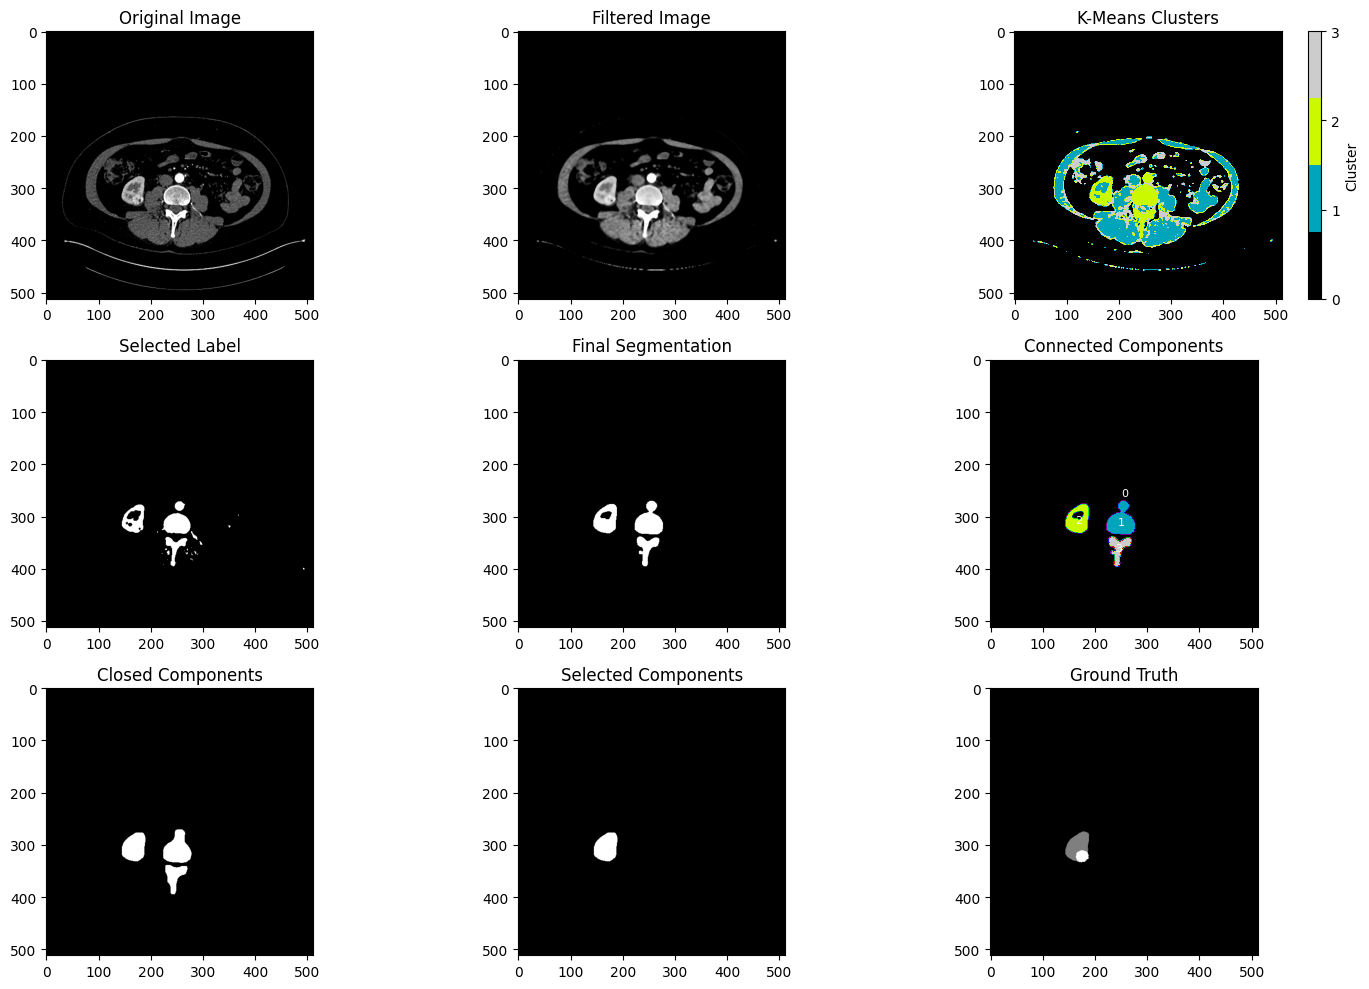

In [507]:
indexIm = 1  # Index entre 0 et 5

# Chargement de l'image et de son masque de segmentation
filename_Segmentation = listImagesabdCT[indexIm]
Img_seg_gt = imread(filename_Segmentation)  # Vérité terrain (mask)
filename= filename_Segmentation[:-9] + '.tiff'
Img_test = imread(filename)  # Image originale

# Vérifications
print('Reading image:', filename)
print('Label values in ground-truth mask image:', np.unique(Img_seg_gt))

if Img_test.shape != Img_seg_gt.shape:
    raise ValueError('Image and mask should have the same shape!')
    
# Run pipeline
segmentation_pipeline(Img_test, Img_seg_gt)

Reading image: ./data/abdominalCT_axial\CTs4.tiff
Label values in ground-truth mask image: [  0 127]


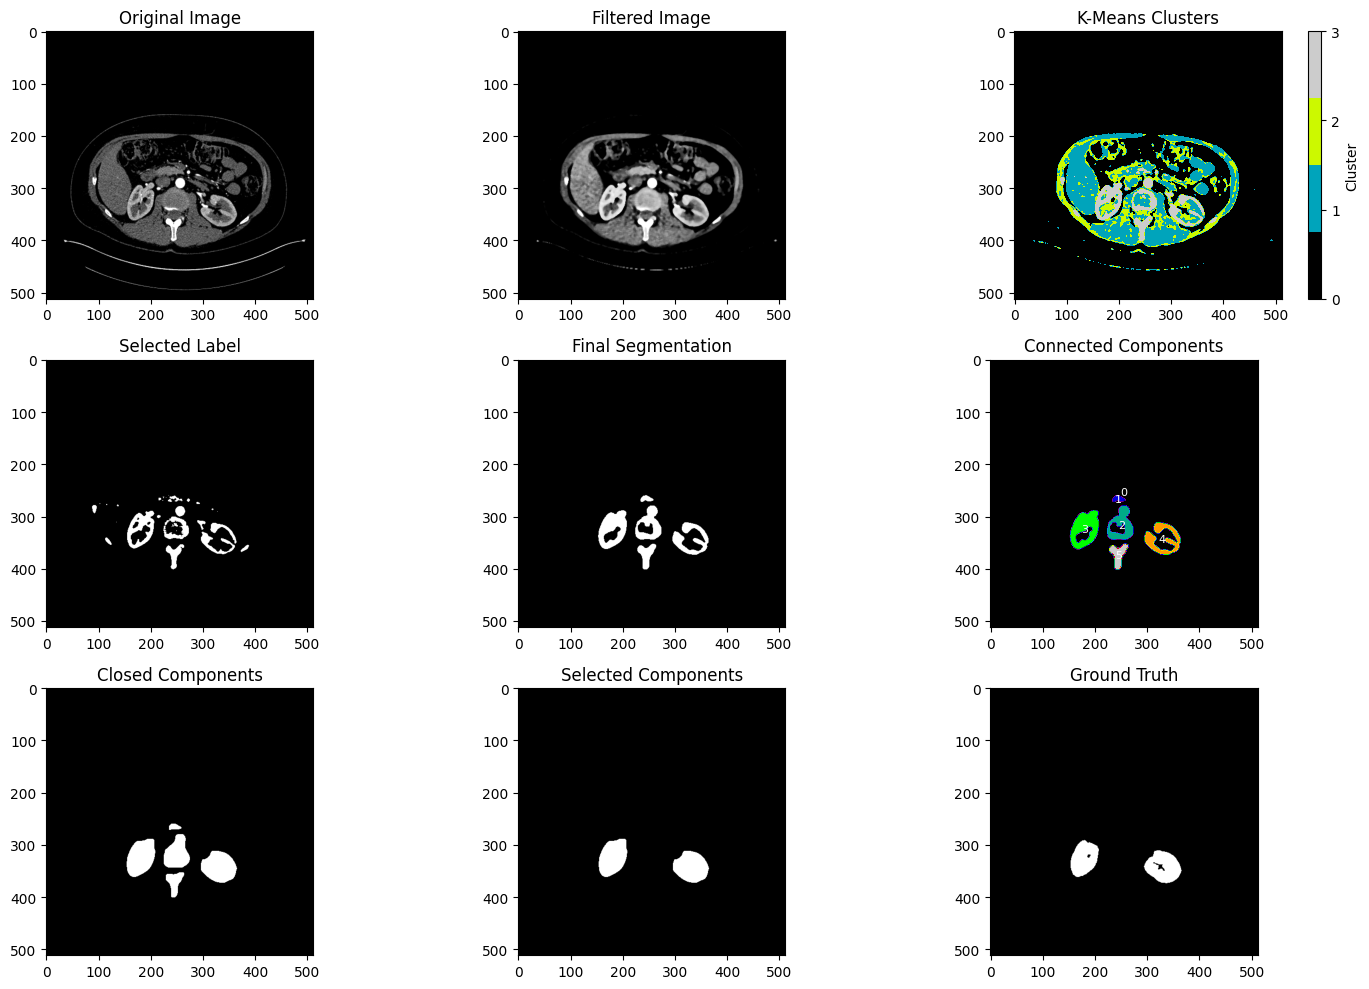

In [508]:
indexIm = 3  # Index entre 0 et 5

# Chargement de l'image et de son masque de segmentation
filename_Segmentation = listImagesabdCT[indexIm]
Img_seg_gt = imread(filename_Segmentation)  # Vérité terrain (mask)
filename= filename_Segmentation[:-9] + '.tiff'
Img_test = imread(filename)  # Image originale

# Vérifications
print('Reading image:', filename)
print('Label values in ground-truth mask image:', np.unique(Img_seg_gt))

if Img_test.shape != Img_seg_gt.shape:
    raise ValueError('Image and mask should have the same shape!')
    
# Run pipeline
segmentation_pipeline(Img_test, Img_seg_gt)

Reading image: ./data/abdominalCT_axial\CTs5.tiff
Label values in ground-truth mask image: [  0 127]


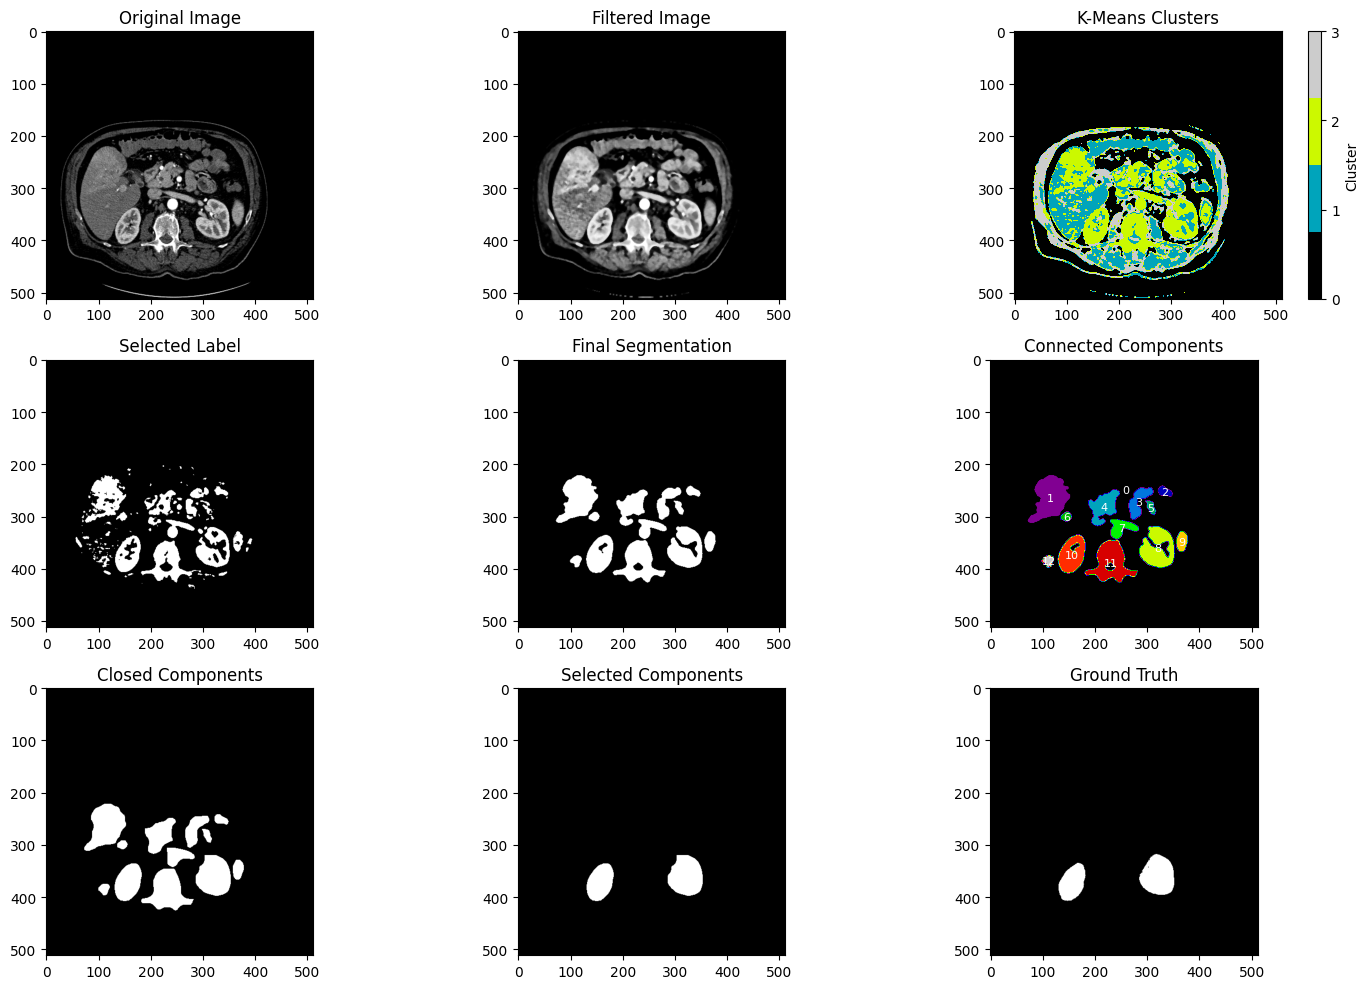

In [509]:
indexIm = 4  # Index entre 0 et 5

# Chargement de l'image et de son masque de segmentation
filename_Segmentation = listImagesabdCT[indexIm]
Img_seg_gt = imread(filename_Segmentation)  # Vérité terrain (mask)
filename= filename_Segmentation[:-9] + '.tiff'
Img_test = imread(filename)  # Image originale

# Vérifications
print('Reading image:', filename)
print('Label values in ground-truth mask image:', np.unique(Img_seg_gt))

if Img_test.shape != Img_seg_gt.shape:
    raise ValueError('Image and mask should have the same shape!')
    
# Run pipeline
segmentation_pipeline(Img_test, Img_seg_gt)